In [1]:
!pip install opencv-python
!pip install plantcv


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import requests
from io import BytesIO
import cv2
import numpy as np
from skimage.morphology import disk, skeletonize, remove_small_objects, binary_opening
from skimage.filters.rank import autolevel, median
import matplotlib.pyplot as plt
from plantcv import plantcv as pcv

In [3]:
# URL of the file
url = "https://github.com/lonespear/aerogel/raw/main/aerogel_co_50mM_magnet_0016.tif"

# Plant CV parameters
pcv.params.text_size = .4
pcv.params.text_thickness = 1
pcv.params.line_thickness = 3
pcv.params.color_sequence = "random"

# Fetch the image from the URL
response = requests.get(url)
image_data = np.asarray(bytearray(response.content), dtype="uint8")

# Decode the image with OpenCV, using grayscale mode
og_img = cv2.imdecode(image_data, cv2.IMREAD_GRAYSCALE)
fib_image = og_img[0:3750,:] # Removing data ribbon at bottom
fib_image = fib_image[0:3750,0:3750]

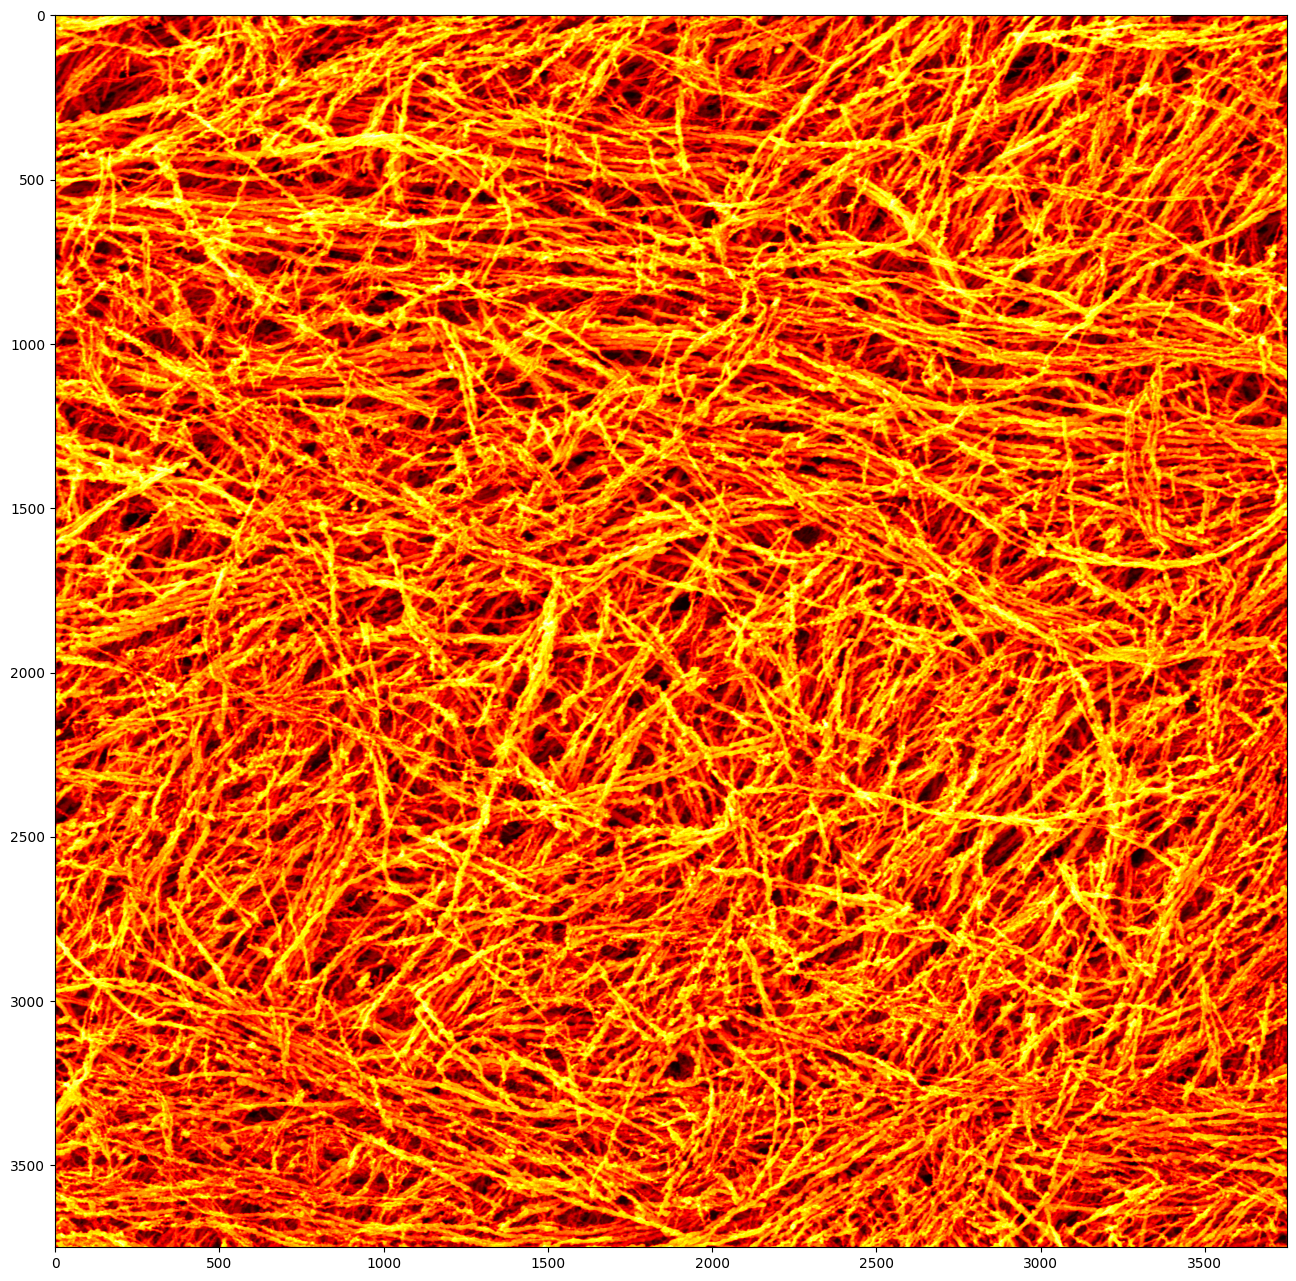

In [5]:
plt.figure(figsize=(20,16))
plt.imshow(fib_image, cmap='hot')

In [6]:
def proc_img(img):
    # Threshold the image
    ret,img = cv2.threshold(img, 127, 255, 0)

    # Step 1: Create an empty skeleton
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    # Get a Cross Shaped Kernel
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

    # making a 5x5 array of all 1's for median filter, and a disk for the autolevel filter
    darray = np.zeros((5, 5)) + 1
    selem = disk(11)

    # Repeat steps 2-4
    while True:
        #Step 2: Open the image
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        #Step 3: Subtract open from the original image
        temp = cv2.subtract(img, open)
        #Step 4: Erode the original image and refine the skeleton
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
        if cv2.countNonZero(img)==0:
            break

    img = cv2.GaussianBlur(skel, (25, 25), 0)
    # img = median(img, darray)
    # img = autolevel(img, selem)
    _, bin_img = cv2.threshold(img, 15, 255, cv2.THRESH_BINARY)
    # bin_img = cv2.Laplacian(bin_img, cv2.CV_16S, ksize=11)
    skel_img = skeletonize(bin_img)
    return skel_img

In [8]:
skel_img = proc_img(fib_image)
skel_int = skel_img.astype(np.uint8)
skel_int = np.clip(skel_int, 0, 255)

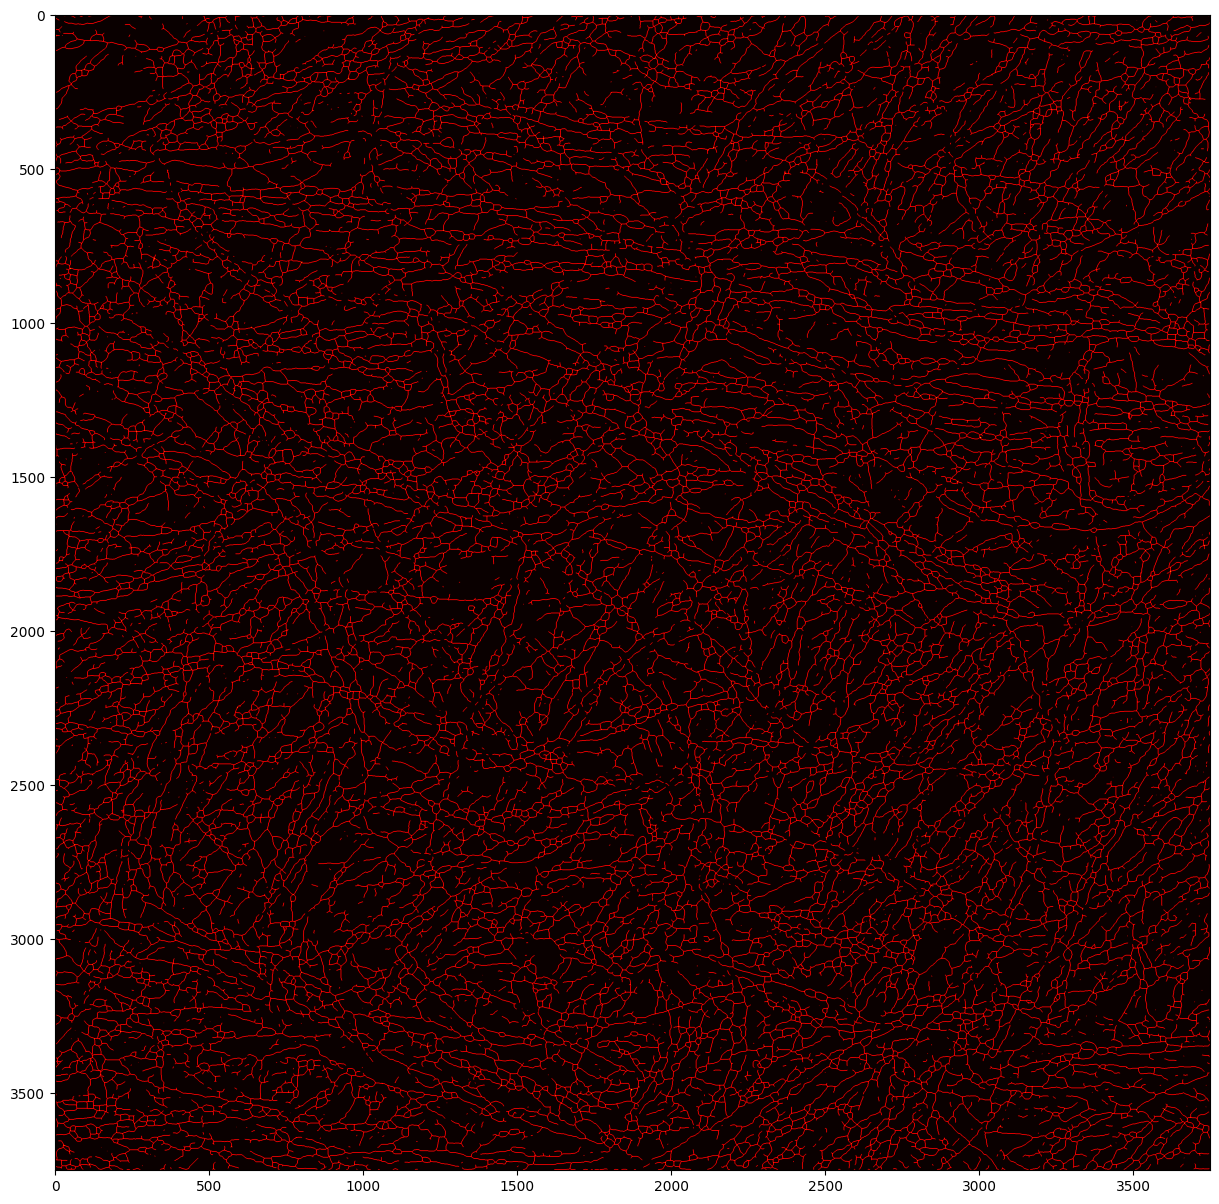

In [9]:
plt.figure(figsize=(20,15))
plt.imshow(skel_int, cmap='hot')

In [11]:
pruned_skel, seg_img, edge_objects = pcv.morphology.prune(skel_img=skel_int, size=20)

7min30sec run time above for full image

In [10]:
plt.figure(figsize=(20,16))
plt.imshow(pruned_skel, cmap='hot')

NameError: name 'pruned_skel' is not defined

<Figure size 2000x1600 with 0 Axes>

In [14]:
branch_pts = pcv.morphology.find_branch_pts(skel_img=pruned_skel)
segments, labels = pcv.morphology.segment_id(skel_img=pruned_skel, objects=edge_objects)

In [15]:
br_pts = []
for i in range(len(branch_pts[:,0])):
    for j in range(len(branch_pts[0,:])):
        if branch_pts[i,j] != 0:
            br_pts.append([j,i])

In [19]:
len(br_pts)

9690

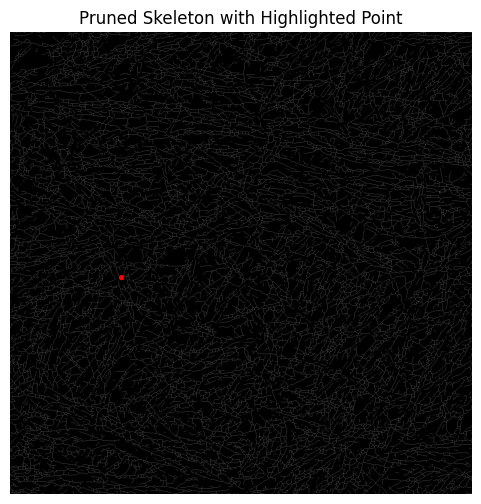

In [18]:
# Assuming pruned_skel is your image
plt.figure(figsize=(6, 6))

# Display pruned_skel
plt.imshow(pruned_skel, cmap='gray')
plt.title("Pruned Skeleton with Highlighted Point")
plt.axis("off")

# Draw a circle around the point [17, 487]
circle = plt.Circle(br_pts[5000], radius=10, color='red', fill=False, linewidth=2)
plt.gca().add_patch(circle)

plt.show()

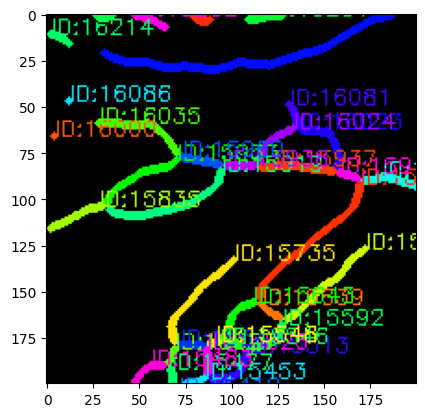

In [37]:
plt.imshow(labels[0:200,0:200])

In [38]:
intersections = {}

for i, cnt in enumerate(br_pts):
    x, y = cnt[0], cnt[1]
    x_window = (x - 5, x + 5)  # buffer window for x
    y_window = (y - 5, y + 5)  # buffer window for y

    intersections[i] = []  # Initialize list for each branch point

    for j, obj in enumerate(edge_objects):
        # Check the first and last points in the edge_object
        first_point = obj[0][0]  # First point in edge_object
        last_point = obj[-1][0]  # Last point in edge_object

        # Extract coordinates based on assumed [x, y] format
        fy, fx = first_point
        ly, lx = last_point

        # Check if either the first or last point is within the window
        if (x_window[0] <= fx <= x_window[1] and y_window[0] <= fy <= y_window[1]) or \
           (x_window[0] <= lx <= x_window[1] and y_window[0] <= ly <= y_window[1]):
            intersections[i].append(j)


KeyboardInterrupt: 

In [62]:
def pair_fiber_intersection(br_pts, edge_objects):
    intersections = {}

    for i, cnt in enumerate(br_pts):
        print(i)
        print(cnt)
        x, y = cnt[0], cnt[1]
        print(x, y)
        x_window = (x - 5, x + 5)  # buffer window for x
        y_window = (y - 5, y + 5)  # buffer window for y
        print(x_window, y_window)

        intersections[i] = []  # Initialize list for each branch point

        for j, obj in enumerate(edge_objects):
            # Check the first and last points in the edge_object
            first_point = obj[0][0]  # First point in edge_object
            last_point = obj[-1][0]  # Last point in edge_object
            print(first_point)
            print(last_point)

            # Extract coordinates based on assumed [x, y] format
            fy, fx = first_point
            ly, lx = last_point

            # Check if either the first or last point is within the window
            if (x_window[0] <= fx <= x_window[1] and y_window[0] <= fy <= y_window[1]) or \
            (x_window[0] <= lx <= x_window[1] and y_window[0] <= ly <= y_window[1]):
                print("yes")
                intersections[i].append(j)
            print("no")
            break
    return intersections

In [63]:
x = pair_fiber_intersection(br_pts, edge_objects[0:100])

0
[3356, 4]
3356 4
(3351, 3361) (-1, 9)
[1881 3748]
[1882 3748]
no
1
[586, 5]
586 5
(581, 591) (0, 10)
[1881 3748]
[1882 3748]
no
2
[886, 6]
886 6
(881, 891) (1, 11)
[1881 3748]
[1882 3748]
no
3
[1535, 7]
1535 7
(1530, 1540) (2, 12)
[1881 3748]
[1882 3748]
no
4
[2750, 7]
2750 7
(2745, 2755) (2, 12)
[1881 3748]
[1882 3748]
no
5
[2919, 7]
2919 7
(2914, 2924) (2, 12)
[1881 3748]
[1882 3748]
no
6
[534, 8]
534 8
(529, 539) (3, 13)
[1881 3748]
[1882 3748]
no
7
[966, 8]
966 8
(961, 971) (3, 13)
[1881 3748]
[1882 3748]
no
8
[783, 10]
783 10
(778, 788) (5, 15)
[1881 3748]
[1882 3748]
no
9
[2856, 10]
2856 10
(2851, 2861) (5, 15)
[1881 3748]
[1882 3748]
no
10
[1794, 11]
1794 11
(1789, 1799) (6, 16)
[1881 3748]
[1882 3748]
no
11
[2517, 11]
2517 11
(2512, 2522) (6, 16)
[1881 3748]
[1882 3748]
no
12
[1261, 13]
1261 13
(1256, 1266) (8, 18)
[1881 3748]
[1882 3748]
no
13
[2035, 13]
2035 13
(2030, 2040) (8, 18)
[1881 3748]
[1882 3748]
no
14
[487, 14]
487 14
(482, 492) (9, 19)
[1881 3748]
[1882 3748]
no


[2766, 924]
2766 924
(2761, 2771) (919, 929)
[1881 3748]
[1882 3748]
no
2249
[2776, 924]
2776 924
(2771, 2781) (919, 929)
[1881 3748]
[1882 3748]
no
2250
[2884, 924]
2884 924
(2879, 2889) (919, 929)
[1881 3748]
[1882 3748]
no
2251
[323, 925]
323 925
(318, 328) (920, 930)
[1881 3748]
[1882 3748]
no
2252
[994, 925]
994 925
(989, 999) (920, 930)
[1881 3748]
[1882 3748]
no
2253
[1943, 925]
1943 925
(1938, 1948) (920, 930)
[1881 3748]
[1882 3748]
no
2254
[614, 927]
614 927
(609, 619) (922, 932)
[1881 3748]
[1882 3748]
no
2255
[2257, 927]
2257 927
(2252, 2262) (922, 932)
[1881 3748]
[1882 3748]
no
2256
[170, 928]
170 928
(165, 175) (923, 933)
[1881 3748]
[1882 3748]
no
2257
[973, 928]
973 928
(968, 978) (923, 933)
[1881 3748]
[1882 3748]
no
2258
[1315, 928]
1315 928
(1310, 1320) (923, 933)
[1881 3748]
[1882 3748]
no
2259
[1325, 928]
1325 928
(1320, 1330) (923, 933)
[1881 3748]
[1882 3748]
no
2260
[1771, 928]
1771 928
(1766, 1776) (923, 933)
[1881 3748]
[1882 3748]
no
2261
[2152, 928]
2152 92

In [64]:
br_pts

[[3356, 4],
 [586, 5],
 [886, 6],
 [1535, 7],
 [2750, 7],
 [2919, 7],
 [534, 8],
 [966, 8],
 [783, 10],
 [2856, 10],
 [1794, 11],
 [2517, 11],
 [1261, 13],
 [2035, 13],
 [487, 14],
 [804, 14],
 [1947, 14],
 [1794, 15],
 [1958, 15],
 [2010, 15],
 [2780, 15],
 [1195, 16],
 [1987, 16],
 [487, 17],
 [741, 17],
 [3318, 17],
 [2679, 18],
 [1172, 19],
 [1940, 19],
 [885, 20],
 [1292, 20],
 [1066, 21],
 [1902, 21],
 [3318, 21],
 [512, 22],
 [2015, 22],
 [2103, 22],
 [734, 23],
 [944, 23],
 [1717, 23],
 [1746, 23],
 [3167, 23],
 [756, 24],
 [758, 24],
 [784, 24],
 [790, 24],
 [2017, 24],
 [2694, 24],
 [500, 25],
 [2238, 26],
 [3609, 26],
 [1514, 27],
 [1961, 27],
 [1963, 27],
 [2019, 27],
 [1727, 28],
 [1776, 28],
 [3375, 28],
 [1787, 29],
 [3359, 29],
 [1107, 30],
 [1509, 30],
 [734, 32],
 [1078, 32],
 [1174, 32],
 [3448, 32],
 [1757, 33],
 [670, 35],
 [1667, 35],
 [1291, 36],
 [1943, 36],
 [1946, 36],
 [2126, 36],
 [1435, 37],
 [2729, 37],
 [2737, 37],
 [644, 38],
 [3529, 38],
 [1062, 39],
 [

In [65]:
br_pts[0]

[3356, 4]